In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
# from numpy import infinity
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib .patches import Patch, Rectangle
from shapely.geometry import Point
from shapely.geometry import LineString

commute21 = pd.read_csv(r"../data/sodb_2021_dochadzka_denne_lm_rk.csv", encoding="windows-1250")
commute11 = pd.read_csv(r"../data/dochadzka_zamestnanie_sodb_2011.csv", sep=";")
commute01 = pd.read_csv(r"../data/dochadzka_zamestnanie_sodb_2001.csv", sep=";")

obce = gpd.read_file(r"../data/liptov_obce.csv", encoding = "windows-1250")
map2 = gpd.read_file(r"../data/geo/liptov.shp")
okresy = gpd.read_file(r"../data/geo/liptov_okresy.shp")
lipt_colors = pd.read_csv(r"../data/colors.csv", sep=";")
map2.drop(columns = ["DOW", "FACC", "IDN3", "NM3", "IDN2", "NM2", "NUTS1", "NUTS1_CODE", "NUTS2", "NUTS2_CODE", "NUTS3", "NUTS3_CODE", "LAU1", "LAU1_CODE", "LAU2", "LAU2_CODE", "VYMERA", "Shape_Area", "Shape_Leng"], inplace = True)
commute11 = (commute11).rename(columns = {"obecA": "obecA", "obecB": "obecB", "POCET": "pocet11"})
commute01 = (commute01).rename(columns = {"Obec trvaleho pobytu": "obecA", "Miesto pracoviska (obec)": "obecB", "POCET": "pocet01"})

commute21[["obecA", "obecB"]] = commute21[["obecA", "obecB"]].astype(str)
commute21["pocet"] = commute21["pocet"].astype(int)
commute11[["obecA", "obecB"]] = commute11[["obecA", "obecB"]].astype(str)
commute11["pocet11"] = commute11["pocet11"].astype(int)
commute01[["obecA", "obecB"]] = commute01[["obecA", "obecB"]].astype(str)
commute01["pocet01"] = commute01["pocet01"].astype(int)


lipt_colors["obec_id"] = lipt_colors["obec_id"].astype(str)
map2["IDN4"] = map2["IDN4"].astype(str)
obce["kod"] = obce["kod"].astype(str)
obce["symbol"] = obce["kod"].apply(lambda code: "o" if (code != "510262") | (code != "510998") else "*")
unique_obce = map2["IDN4"].apply(str).tolist()
print(obce.head())
commute11 = commute11[commute11["Periodicita dochadzky"] == 1]
commute11 = commute11[commute11["obecA"].isin(unique_obce) & commute11["obecB"].isin(unique_obce)]
commute01 = commute01[commute01["Periodicita dochadzky"] == 1]
commute01 = commute01[commute01["obecA"].isin(unique_obce) & commute01["obecB"].isin(unique_obce)]

obce_gdf = gpd.GeoDataFrame(
    obce,
    geometry=[Point(xy) for xy in zip(obce["x"], obce["y"])],
    crs="EPSG:5514"
)

     code              nazov            kod_obce typ okMesto kMesto IDN3  \
0  027 32               Huty  510459.00000000000  vo       0      0  505   
1  027 32        Malé Borové  510840.00000000000  vo       0      0  505   
2  027 32       Veľké Borové  511137.00000000000  vo       0      0  505   
3  031 01     Pavčina Lehota  510912.00000000000  vo       0      0  505   
4  031 01  Liptovský Trnovec  510777.00000000000  vo       0      0  505   

                 NM3 IDN2       NM2 NAZOVOBCE KODOBCE            nazov_1  \
0  Liptovský Mikuláš    5  Žilinský                 0               Huty   
1  Liptovský Mikuláš    5  Žilinský                 0        Malé Borové   
2  Liptovský Mikuláš    5  Žilinský                 0       Veľké Borové   
3  Liptovský Mikuláš    5  Žilinský                 0     Pavčina Lehota   
4  Liptovský Mikuláš    5  Žilinský                 0  Liptovský Trnovec   

      kod             obyv            x             y symbol  
0  510459  168.00000000

In [2]:
all21 = (
    commute21
    .groupby("obecA", group_keys = False)["pocet"]
    .sum()
)
outer21 = (
    commute21[commute21["obecA"] != commute21["obecB"]]
    .groupby("obecA", group_keys=False)["pocet"]
    .sum()
)
inter21 = (
    commute21[commute21["obecA"] == commute21["obecB"]]
    .groupby("obecA", group_keys=False)["pocet"]
    .sum()
)

all21_df = all21.reset_index().rename(columns = {"pocet": "spolu21"})
inter21_df = inter21.reset_index().rename(columns = {"pocet": "v_obci21"})
outer21_df = outer21.reset_index().rename(columns = {"pocet": "mimo_obce21"})

table21 = all21_df.merge(
    outer21_df.merge(
    inter21_df,
    on = "obecA",
    how = "left"
), on = "obecA", how = "left").fillna(0)
table21["mimo_percent21"] = (table21["mimo_obce21"]/table21["spolu21"]*100).round(1)
table21["vnutri_percent21"] = (table21["v_obci21"]/table21["spolu21"]*100).round(1)
print(table21)

     obecA  spolu21  mimo_obce21  v_obci21  mimo_percent21  vnutri_percent21
0   507300      149          131      18.0            87.9              12.1
1   507393       55           53       2.0            96.4               3.6
2   507407       47           42       5.0            89.4              10.6
3   510262     6561         1380    5181.0            21.0              79.0
4   510271      141          135       6.0            95.7               4.3
..     ...      ...          ...       ...             ...               ...
76  511196      243          192      51.0            79.0              21.0
77  511200      116          106      10.0            91.4               8.6
78  556807       17           17       0.0           100.0               0.0
79  558281      226          200      26.0            88.5              11.5
80  580287      306          295      11.0            96.4               3.6

[81 rows x 6 columns]


In [3]:
all11 = (
    commute11
    .groupby("obecA", group_keys = False)["pocet11"]
    .sum()
)
outer11 = (
    commute11[commute11["obecA"] != commute11["obecB"]]
    .groupby("obecA", group_keys=False)["pocet11"]
    .sum()
)
inter11 = (
    commute11[commute11["obecA"] == commute11["obecB"]]
    .groupby("obecA", group_keys=False)["pocet11"]
    .sum()
)

all11_df = all11.reset_index().rename(columns = {"pocet11": "spolu11"})
inter11_df = inter11.reset_index().rename(columns = {"pocet11": "v_obci11"})
outer11_df = outer11.reset_index().rename(columns = {"pocet11": "mimo_obce11"})

table11 = all11_df.merge(
    outer11_df.merge(
    inter11_df,
    on = "obecA",
    how = "left"
), on = "obecA", how = "left").fillna(0)
table11["mimo_percent11"] = (table11["mimo_obce11"]/table11["spolu11"]*100).round(1)
table11["vnutri_percent11"] = (table11["v_obci11"]/table11["spolu11"]*100).round(1)
print(table11)

     obecA  spolu11  mimo_obce11  v_obci11  mimo_percent11  vnutri_percent11
0   507300      115           99      16.0            86.1              13.9
1   507393       75           67       8.0            89.3              10.7
2   507407       46           42       4.0            91.3               8.7
3   510262     7844         1331    6513.0            17.0              83.0
4   510271      146          138       8.0            94.5               5.5
..     ...      ...          ...       ...             ...               ...
76  511196      336          251      85.0            74.7              25.3
77  511200      118          101      17.0            85.6              14.4
78  556807       19           15       4.0            78.9              21.1
79  558281      243          195      48.0            80.2              19.8
80  580287      367          326      41.0            88.8              11.2

[81 rows x 6 columns]


In [5]:
all01 = (
    commute01
    .groupby("obecA", group_keys = False)["pocet01"]
    .sum()
)
outer01 = (
    commute01[commute01["obecA"] != commute01["obecB"]]
    .groupby("obecA", group_keys=False)["pocet01"]
    .sum()
)
inter01 = (
    commute01[commute01["obecA"] == commute01["obecB"]]
    .groupby("obecA", group_keys=False)["pocet01"]
    .sum()
)

all01_df = all01.reset_index().rename(columns = {"pocet01": "spolu01"})
inter01_df = inter01.reset_index().rename(columns = {"pocet01": "v_obci01"})
outer01_df = outer01.reset_index().rename(columns = {"pocet01": "mimo_obce01"})

table01 = all01_df.merge(
    outer01_df.merge(
    inter01_df,
    on = "obecA",
    how = "left"
), on = "obecA", how = "left").fillna(0)
table01["mimo_percent01"] = (table01["mimo_obce01"]/table01["spolu01"]*100).round(1)
table01["vnutri_percent01"] = (table01["v_obci01"]/table01["spolu01"]*100).round(1)
print(table01)

     obecA  spolu01  mimo_obce01  v_obci01  mimo_percent01  vnutri_percent01
0   507300      150          131      19.0            87.3              12.7
1   507393       75           72       3.0            96.0               4.0
2   507407       51           43       8.0            84.3              15.7
3   510262    11464         1413   10051.0            12.3              87.7
4   510271      152          125      27.0            82.2              17.8
..     ...      ...          ...       ...             ...               ...
76  511196      418          351      67.0            84.0              16.0
77  511200      137          122      15.0            89.1              10.9
78  556807       28           24       4.0            85.7              14.3
79  558281      328          250      78.0            76.2              23.8
80  580287      515          460      55.0            89.3              10.7

[81 rows x 6 columns]


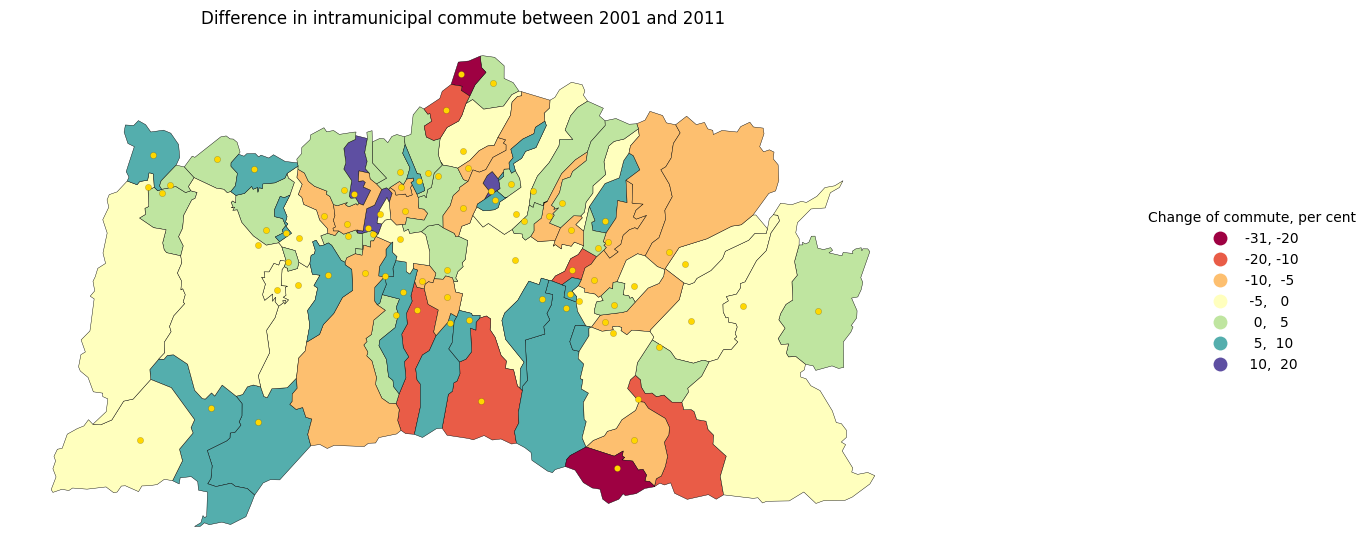

In [6]:
change01_11 = table01.merge(
    table11,
    left_on = "obecA",
    right_on = "obecA",
    how = "left"
)
change01_11["change_mimo"] = change01_11["mimo_percent11"] - change01_11["mimo_percent01"]
change01_11["change_vnutri"] = change01_11["vnutri_percent11"] - change01_11["vnutri_percent01"]
tablemap = map2.merge(
    change01_11,
    left_on = "IDN4",
    right_on = "obecA",
    how = "left"
)
custom_bins = [-20, -10, -5, 0, 5, 10, 20]
# min1 = change01_11["change_vnutri"].min()
# max1 = change01_11["change_vnutri"].max()
# abs_max1 = max(abs(min1), abs(max1))
# num_bins = 4
# bin_width = (2 * abs_max1)/num_bins
# bins = [-abs_max1 + i * bin_width for i in range(num_bins + 1)]
tablemap["interval"] = pd.cut(tablemap["change_vnutri"], bins = custom_bins, include_lowest = False, labels = False)
# print(tablemap.head())
plt.figure(figsize = (11.69, 8.27))
tablemap.plot(
    ax = plt.gca(),
    column = "change_vnutri",
    cmap = "Spectral",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": custom_bins},
    legend_kwds = {
        "title": "Change of commute, per cent",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)

obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)

plt.title("Difference in intramunicipal commute between 2001 and 2011")
plt.axis(False)
# plt.savefig("../result_maps/autonomy/LM_RK_change_2001_2011.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

    obecA  spolu11  mimo_obce11  v_obci11  mimo_percent11  vnutri_percent11  \
0  507300      115           99      16.0            86.1              13.9   
1  507393       75           67       8.0            89.3              10.7   
2  507407       46           42       4.0            91.3               8.7   
3  510262     7844         1331    6513.0            17.0              83.0   
4  510271      146          138       8.0            94.5               5.5   

   spolu21  mimo_obce21  v_obci21  mimo_percent21  vnutri_percent21  \
0      149          131      18.0            87.9              12.1   
1       55           53       2.0            96.4               3.6   
2       47           42       5.0            89.4              10.6   
3     6561         1380    5181.0            21.0              79.0   
4      141          135       6.0            95.7               4.3   

   change_mimo  change_vnutri  
0          1.8           -1.8  
1          7.1           -7.1  
2 

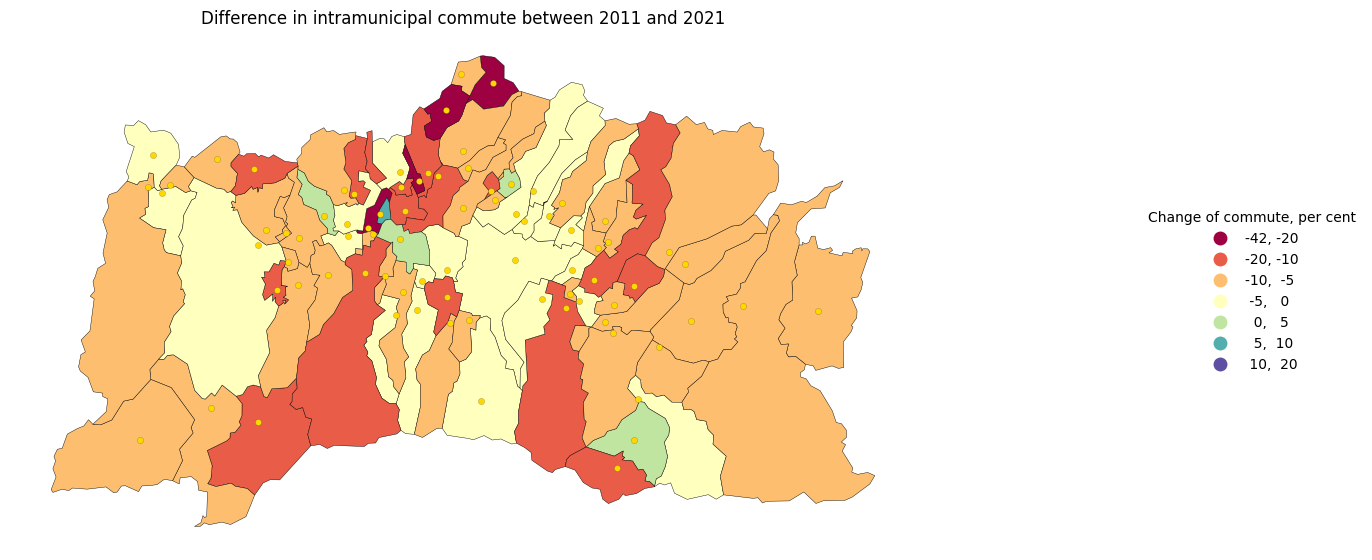

In [7]:
change11_21 = table11.merge(
    table21,
    left_on = "obecA",
    right_on = "obecA",
    how = "left"
)
change11_21["change_mimo"] = change11_21["mimo_percent21"] - change11_21["mimo_percent11"]
change11_21["change_vnutri"] = change11_21["vnutri_percent21"] - change11_21["vnutri_percent11"]
print(change11_21.head())
tablemap2 = map2.merge(
    change11_21,
    left_on = "IDN4",
    right_on = "obecA",
    how = "left"
)

# min2 = change11_21["change_vnutri"].min()
# max2 = change11_21["change_vnutri"].max()
# abs_max2 = max(abs(min2), abs(max2))
# num_bins = 4
# bin_width = (2 * abs_max2)/num_bins
# bins = [-abs_max2 + i * bin_width for i in range(num_bins + 1)]
tablemap2["interval"] = pd.cut(tablemap2["change_vnutri"], bins = custom_bins, include_lowest = False, labels = False)
# print(tablemap.head())
plt.figure(figsize = (11.69, 8.27))
tablemap2.plot(
    ax = plt.gca(),
    column = "change_vnutri",
    cmap = "Spectral",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": custom_bins},
    legend_kwds = {
        "title": "Change of commute, per cent",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)

plt.title("Difference in intramunicipal commute between 2011 and 2021")
plt.axis(False)
# plt.savefig("../result_maps/autonomy/LM_RK_change_2011_2021.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

    obecA  spolu01  mimo_obce01  v_obci01  mimo_percent01  vnutri_percent01  \
0  507300      150          131      19.0            87.3              12.7   
1  507393       75           72       3.0            96.0               4.0   
2  507407       51           43       8.0            84.3              15.7   
3  510262    11464         1413   10051.0            12.3              87.7   
4  510271      152          125      27.0            82.2              17.8   

   spolu21  mimo_obce21  v_obci21  mimo_percent21  vnutri_percent21  \
0      149          131      18.0            87.9              12.1   
1       55           53       2.0            96.4               3.6   
2       47           42       5.0            89.4              10.6   
3     6561         1380    5181.0            21.0              79.0   
4      141          135       6.0            95.7               4.3   

   change_mimo  change_vnutri  
0          0.6           -0.6  
1          0.4           -0.4  
2 

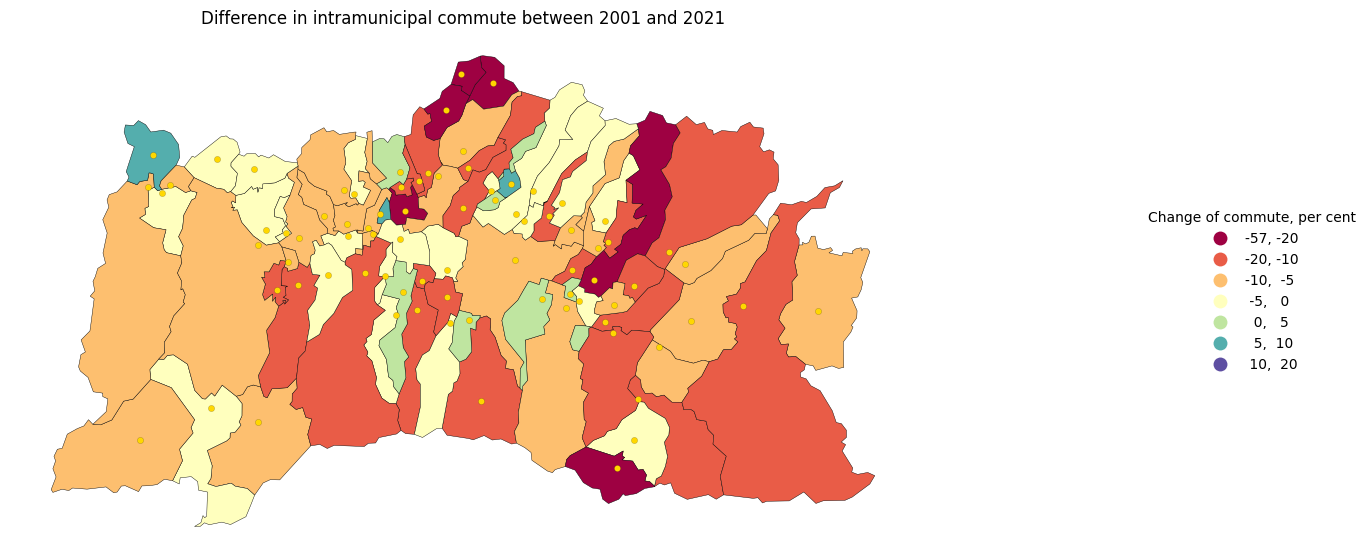

In [8]:
change01_21 = table01.merge(
    table21,
    left_on = "obecA",
    right_on = "obecA",
    how = "left"
)
change01_21["change_mimo"] = change11_21["mimo_percent21"] - change01_21["mimo_percent01"]
change01_21["change_vnutri"] = change11_21["vnutri_percent21"] - change01_21["vnutri_percent01"]
print(change01_21.head())
tablemap3 = map2.merge(
    change01_21,
    left_on = "IDN4",
    right_on = "obecA",
    how = "left"
)

# min3 = change01_21["change_vnutri"].min()
# max3 = change01_21["change_vnutri"].max()
# abs_max3 = max(abs(min3), abs(max3))
# num_bins = 4
# bin_width = (2 * abs_max3)/num_bins
# bins = [-abs_max3 + i * bin_width for i in range(num_bins + 1)]
tablemap3["interval"] = pd.cut(tablemap3["change_vnutri"], bins = custom_bins, include_lowest = False, labels = False)
# print(tablemap.head())
plt.figure(figsize = (11.69, 8.27))
tablemap3.plot(
    ax = plt.gca(),
    column = "change_vnutri",
    cmap = "Spectral",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": custom_bins},
    legend_kwds = {
        "title": "Change of commute, per cent",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)

plt.title("Difference in intramunicipal commute between 2001 and 2021")
plt.axis(False)
# plt.savefig("../result_maps/autonomy/LM_RK_change_2001_2021.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

57
79


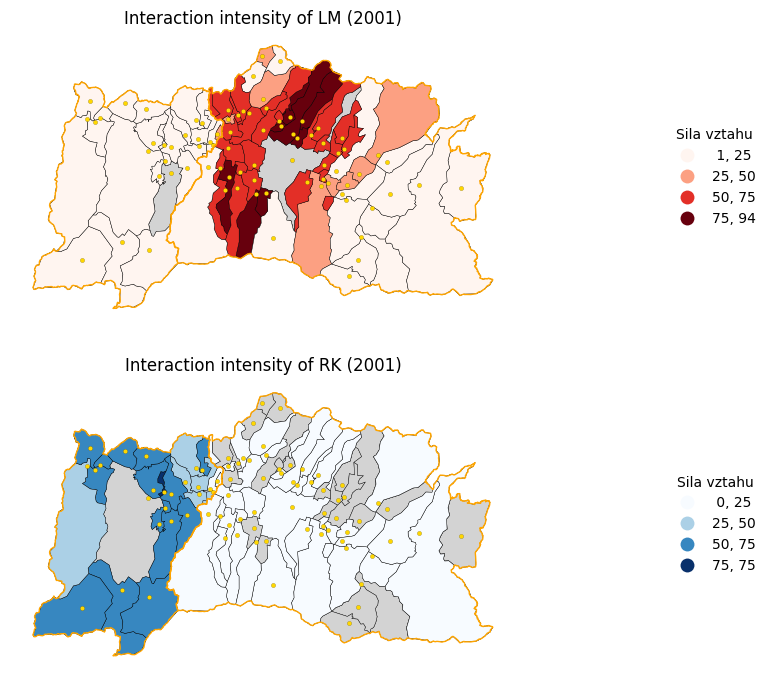

In [11]:
distance = pd.read_csv(r"../data/vzdialenost_obce.csv", sep = ";")
# print(distance.columns)
distance[["obec_id", "mesto_id"]] = distance[["obec_id", "mesto_id"]].astype(str)
distance["flow"] = distance[["obec_id", "mesto_id"]].agg("-".join, axis = 1)
distance.drop(columns = {"pocet_dochadzajucich"}, inplace = True)
# print(distance.head())
# print(table01.columns)

dist01 = commute01.merge(
    table01[["obecA", "spolu01"]],
    left_on = "obecA",
    right_on = "obecA",
    how = "left"
)

dist01 = dist01[(dist01["obecB"] == "510262") | (dist01["obecB"] == "510998")]
dist01["flow"] = dist01[["obecA", "obecB"]].agg("-".join, axis = 1)
distmap01 = dist01.merge(
    map2,
    left_on = "obecA",
    right_on = "IDN4",
    how = "left"
)

distmap01 = distmap01.merge(
    distance,
    left_on = "flow",
    right_on = "flow",
    how = "left"
).fillna(0)
distmap01 = distmap01[distmap01["obecA"] != distmap01["obecB"]]
distmap01["intensity"] = distmap01["pocet01"]/distmap01["spolu01"]*100
distmap01 = gpd.GeoDataFrame(distmap01, geometry = "geometry")
# print(distmap01.shape[0])
dist_lm_01 = (
    distmap01[distmap01["obecB"] == "510262"]
).replace(np.inf, 0, inplace = False)
dist_rk_01 = (
    distmap01[distmap01["obecB"] == "510998"]
).replace(np.inf, 0, inplace = False)
print(dist_rk_01.shape[0])
print(dist_lm_01.shape[0])

distance_bins = [25, 50, 75]
plt.figure(figsize = (11.69, 8.27))
# ------------------------------ Gravity force of LM ------------------------------
plt.subplot(2, 1, 1)
dist_lm_01["interval"] = pd.cut(dist_lm_01["intensity"], bins = distance_bins, include_lowest = False, labels = False)
map2.plot(
    ax = plt.gca(),
    color = "lightgray",
    edgecolor = "black",
    linewidth = 0.3
)
dist_lm_01.plot(
    ax = plt.gca(),
    column = "intensity",
    cmap = "Reds",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": distance_bins},
    legend_kwds = {
        "title": "Sila vztahu",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 1.0
)
plt.title("Interaction intensity of LM (2001)")
plt.axis(False)

# ------------------------------ Gravity force of RK ------------------------------
plt.subplot(2, 1, 2)
dist_rk_01["interval"] = pd.cut(dist_rk_01["intensity"], bins = distance_bins, include_lowest = False, labels = False)
map2.plot(
    ax = plt.gca(),
    color = "lightgray",
    edgecolor = "black",
    linewidth = 0.3
)
dist_rk_01.plot(
    ax = plt.gca(),
    column = "intensity",
    cmap = "Blues",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": distance_bins},
    legend_kwds = {
        "title": "Sila vztahu",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 1.0
)
plt.title("Interaction intensity of RK (2001)")
plt.axis(False)
plt.savefig("../result_maps/interaction/LM_RK_interaction_2001_map.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

66
77


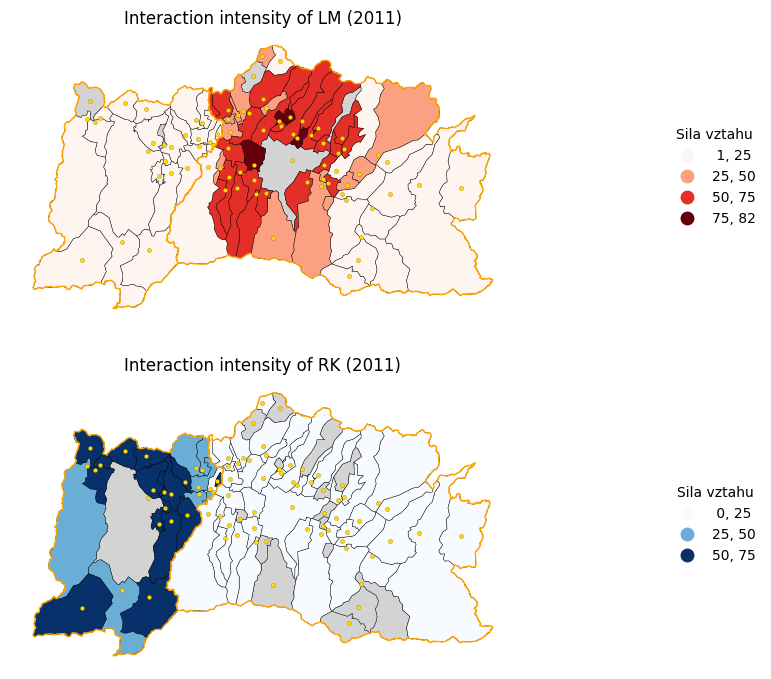

In [12]:
dist11 = commute11.merge(
    table11[["obecA", "spolu11"]],
    left_on = "obecA",
    right_on = "obecA",
    how = "left"
)

dist11 = dist11[(dist11["obecB"] == "510262") | (dist11["obecB"] == "510998")]
dist11["flow"] = dist11[["obecA", "obecB"]].agg("-".join, axis = 1)
distmap11 = dist11.merge(
    map2,
    left_on = "obecA",
    right_on = "IDN4",
    how = "left"
)

distmap11 = distmap11.merge(
    distance,
    left_on = "flow",
    right_on = "flow",
    how = "left"
).fillna(0)
distmap11 = distmap11[distmap11["obecA"] != distmap11["obecB"]]
distmap11["intensity"] = distmap11["pocet11"]/distmap11["spolu11"]*100
distmap11 = gpd.GeoDataFrame(distmap11, geometry = "geometry")
# print(distmap01.shape[0])
dist_lm_11 = (
    distmap11[distmap11["obecB"] == "510262"]
).replace(np.inf, 0, inplace = False)
dist_rk_11 = (
    distmap11[distmap11["obecB"] == "510998"]
).replace(np.inf, 0, inplace = False)
print(dist_rk_11.shape[0])
print(dist_lm_11.shape[0])
plt.figure(figsize = (11.69, 8.27))
# ------------------------------ Gravity force of LM ------------------------------
plt.subplot(2, 1, 1)
dist_lm_11["interval"] = pd.cut(dist_lm_11["intensity"], bins = distance_bins, include_lowest = False, labels = False)
map2.plot(
    ax = plt.gca(),
    color = "lightgray",
    edgecolor = "black",
    linewidth = 0.3
)
dist_lm_11.plot(
    ax = plt.gca(),
    column = "intensity",
    cmap = "Reds",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": distance_bins},
    legend_kwds = {
        "title": "Sila vztahu",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 1.0
)
plt.title("Interaction intensity of LM (2011)")
plt.axis(False)

# ------------------------------ Gravity force of RK ------------------------------
plt.subplot(2, 1, 2)
dist_rk_11["interval"] = pd.cut(dist_rk_11["intensity"], bins = distance_bins, include_lowest = False, labels = False)
map2.plot(
    ax = plt.gca(),
    color = "lightgray",
    edgecolor = "black",
    linewidth = 0.3
)
dist_rk_11.plot(
    ax = plt.gca(),
    column = "intensity",
    cmap = "Blues",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": distance_bins},
    legend_kwds = {
        "title": "Sila vztahu",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 1.0
)
plt.title("Interaction intensity of RK (2011)")
plt.axis(False)
plt.savefig("../result_maps/interaction/LM_RK_interaction_2011_map.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

70
80


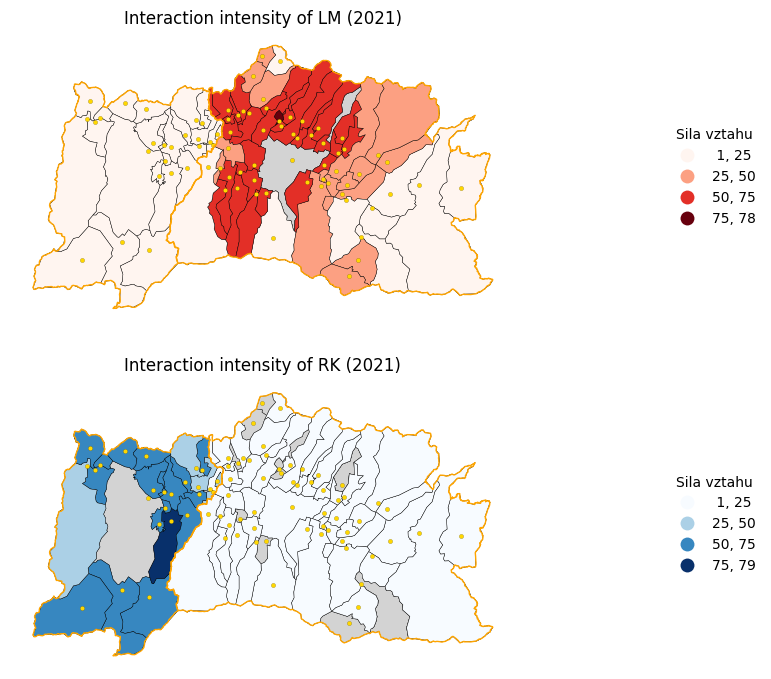

In [13]:
dist21 = commute21.merge(
    table21[["obecA", "spolu21"]],
    left_on = "obecA",
    right_on = "obecA",
    how = "left"
)

dist21 = dist21[(dist21["obecB"] == "510262") | (dist21["obecB"] == "510998")]
dist21["flow"] = dist21[["obecA", "obecB"]].agg("-".join, axis = 1)
distmap21 = dist21.merge(
    map2,
    left_on = "obecA",
    right_on = "IDN4",
    how = "left"
)

distmap21 = distmap21.merge(
    distance,
    left_on = "flow",
    right_on = "flow",
    how = "left"
).fillna(0)
distmap21 = distmap21[distmap21["obecA"] != distmap21["obecB"]]
distmap21["intensity"] = distmap21["pocet"]/distmap21["spolu21"]*100
distmap21 = gpd.GeoDataFrame(distmap21, geometry = "geometry")
# print(distmap01.shape[0])
dist_lm_21 = (
    distmap21[distmap21["obecB"] == "510262"]
).replace(np.inf, 0, inplace = False)
dist_rk_21 = (
    distmap21[distmap21["obecB"] == "510998"]
).replace(np.inf, 0, inplace = False)
print(dist_rk_21.shape[0])
print(dist_lm_21.shape[0])
plt.figure(figsize = (11.69, 8.27))
# ------------------------------ Gravity force of LM ------------------------------
plt.subplot(2, 1, 1)
dist_lm_21["interval"] = pd.cut(dist_lm_21["intensity"], bins = distance_bins, include_lowest = False, labels = False)
map2.plot(
    ax = plt.gca(),
    color = "lightgray",
    edgecolor = "black",
    linewidth = 0.3
)
dist_lm_21.plot(
    ax = plt.gca(),
    column = "intensity",
    cmap = "Reds",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": distance_bins},
    legend_kwds = {
        "title": "Sila vztahu",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 1.0
)
plt.title("Interaction intensity of LM (2021)")
plt.axis(False)

# ------------------------------ Gravity force of RK ------------------------------
plt.subplot(2, 1, 2)
dist_rk_21["interval"] = pd.cut(dist_rk_21["intensity"], bins = distance_bins, include_lowest = False, labels = False)
map2.plot(
    ax = plt.gca(),
    color = "lightgray",
    edgecolor = "black",
    linewidth = 0.3
)
dist_rk_21.plot(
    ax = plt.gca(),
    column = "intensity",
    cmap = "Blues",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": distance_bins},
    legend_kwds = {
        "title": "Sila vztahu",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 1.0
)
plt.title("Interaction intensity of RK (2021)")
plt.axis(False)
plt.savefig("../result_maps/interaction/LM_RK_interaction_2021_map.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

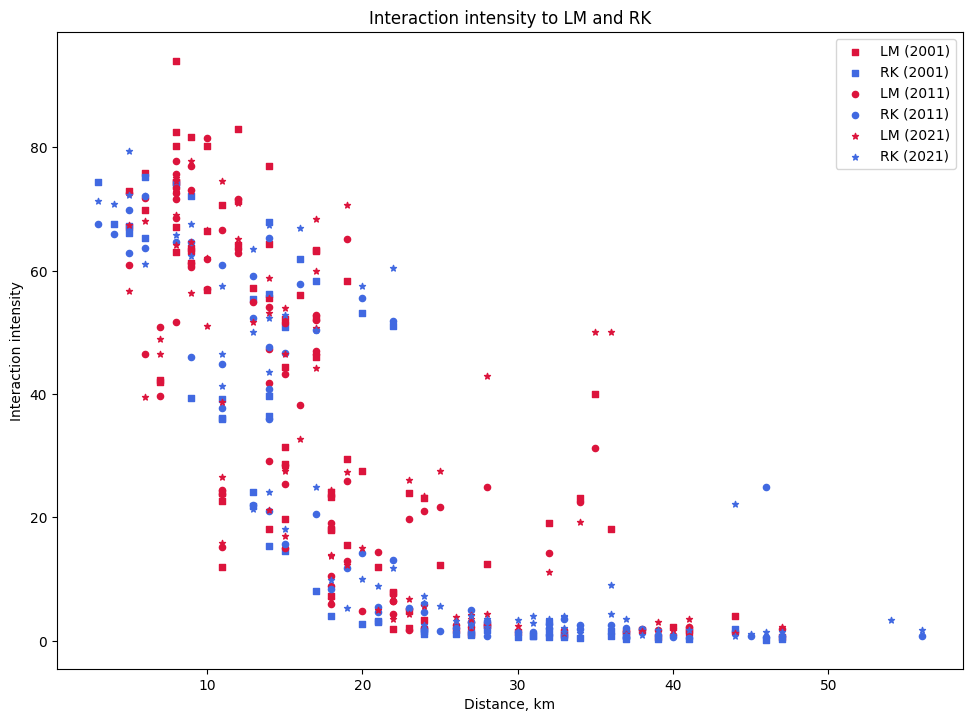

In [14]:
plt.figure(figsize = (11.69, 8.27))

dist_lm_01.plot(kind = "scatter", x = "vzdialenost_km", y = "intensity", ax = plt.gca(), marker = "s", color = "crimson", label = "LM (2001)")
dist_rk_01.plot(kind = "scatter", x = "vzdialenost_km", y = "intensity", ax = plt.gca(), marker = "s", color = "royalblue", label = "RK (2001)")
dist_lm_11.plot(kind = "scatter", x = "vzdialenost_km", y = "intensity", ax = plt.gca(), marker = "o", color = "crimson", label = "LM (2011)")
dist_rk_11.plot(kind = "scatter", x = "vzdialenost_km", y = "intensity", ax = plt.gca(), marker = "o", color = "royalblue", label = "RK (2011)")
dist_lm_21.plot(kind = "scatter", x = "vzdialenost_km", y = "intensity", ax = plt.gca(), marker = "*", color = "crimson", label = "LM (2021)")
dist_rk_21.plot(kind = "scatter", x = "vzdialenost_km", y = "intensity", ax = plt.gca(), marker = "*", color = "royalblue", label = "RK (2021)")
plt.xlabel("Distance, km")
plt.ylabel("Interaction intensity")
plt.title("Interaction intensity to LM and RK")
# plt.savefig("../result_maps/interaction/LM_RK_interaction_plot_both.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

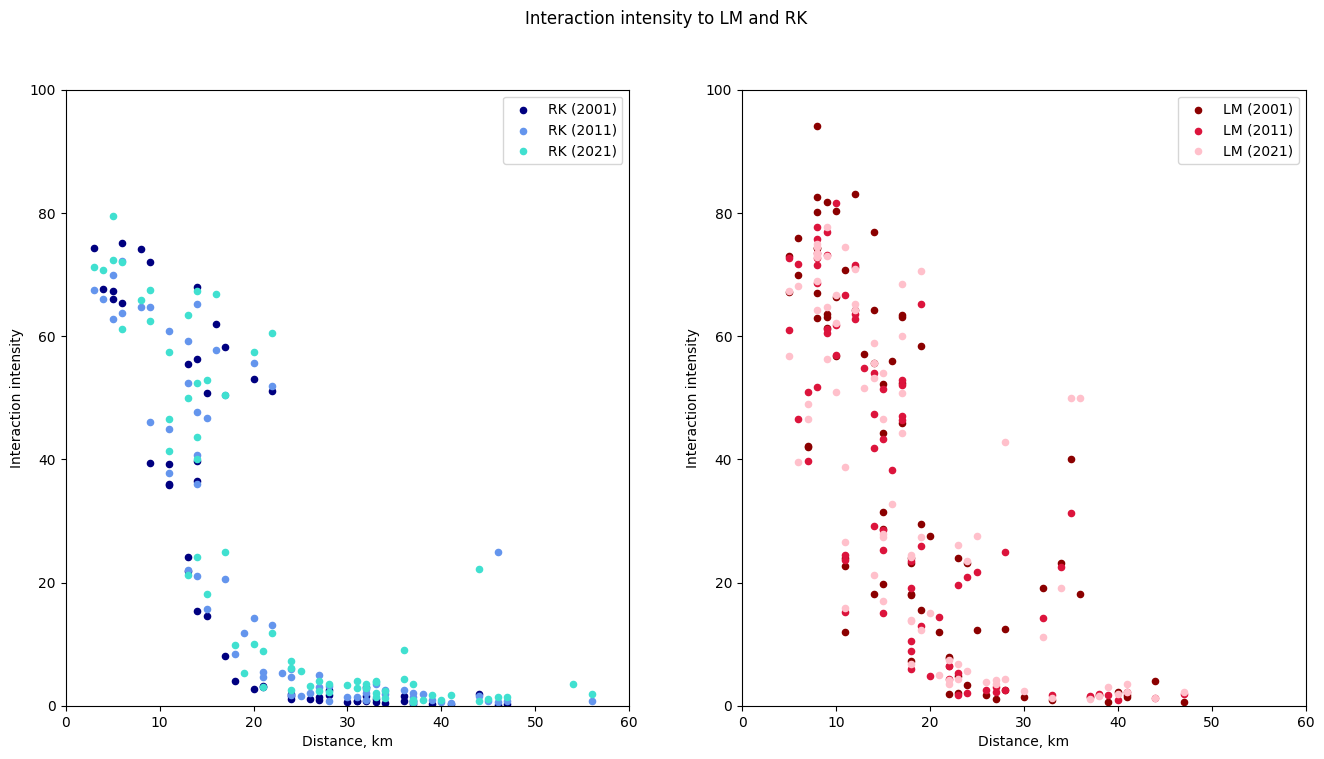

In [18]:
plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
ax1 = plt.gca()
dist_rk_01.plot(kind = "scatter", x = "vzdialenost_km", y = "intensity", color = "navy", label = "RK (2001)", ax = ax1)
dist_rk_11.plot(kind = "scatter", x = "vzdialenost_km", y = "intensity", color = "cornflowerblue", label = "RK (2011)", ax = ax1)
dist_rk_21.plot(kind = "scatter", x = "vzdialenost_km", y = "intensity", color = "turquoise", label = "RK (2021)", ax = ax1)
plt.xlabel("Distance, km")
plt.ylabel("Interaction intensity")

plt.subplot(1, 2, 2)
ax2 = plt.gca()
dist_lm_01.plot(kind = "scatter", x = "vzdialenost_km", y = "intensity", color = "darkred", label = "LM (2001)", ax = ax2)
dist_lm_11.plot(kind = "scatter", x = "vzdialenost_km", y = "intensity", color = "crimson", label = "LM (2011)", ax = ax2)
dist_lm_21.plot(kind = "scatter", x = "vzdialenost_km", y = "intensity", color = "pink", label = "LM (2021)", ax = ax2)
plt.xlabel("Distance, km")
plt.ylabel("Interaction intensity")

ax1.set_xlim(0, 60)
ax1.set_ylim(0, 100)
ax2.set_xlim(0, 60)
ax2.set_ylim(0, 100)

plt.suptitle("Interaction intensity to LM and RK")
plt.savefig("../result_maps/interaction/LM_RK_interaction_plot_both_div.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

<class 'geopandas.geodataframe.GeoDataFrame'>


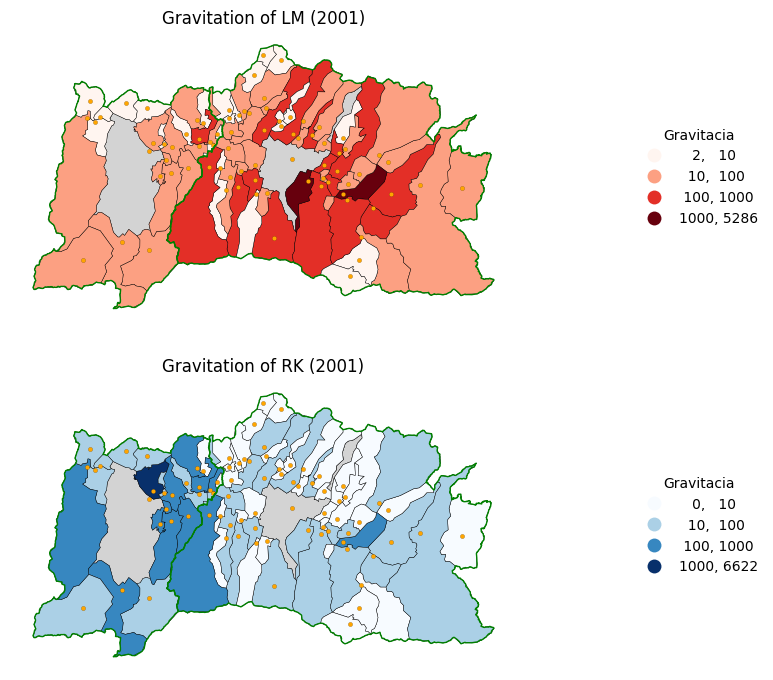

In [94]:
gravity01 = (
    commute01
    .groupby("obecB", group_keys=False)["pocet01"]
    .sum()
)
gravity01 = gravity01.reset_index()
gravity01["pocet01_lm"] = gravity01.loc[gravity01["obecB"] == "510262", "pocet01"].iloc[0]
gravity01["pocet01_rk"] = gravity01.loc[gravity01["obecB"] == "510998", "pocet01"].iloc[0]

gravity01 = gravity01.merge(
    distance[distance["mesto_id"] == "510262"][["obec_id", "vzdialenost_km"]],
    left_on = "obecB",
    right_on = "obec_id",
    how = "left"
).rename(columns = {"vzdialenost_km": "vzdialenost_lm"})

gravity01 = gravity01.merge(
    distance[distance["mesto_id"] == "510998"][["obec_id", "vzdialenost_km"]],
    left_on = "obecB",
    right_on = "obec_id",
    how = "left"
).rename(columns = {"vzdialenost_km": "vzdialenost_rk"})
gravity01 = gravity01[gravity01["vzdialenost_lm"] != 0]
gravity01 = gravity01[gravity01["vzdialenost_rk"] != 0]

gravity01["gravity_lm"] = (gravity01["pocet01"]*gravity01["pocet01_lm"]/gravity01["vzdialenost_lm"]**2)/100
gravity01["gravity_rk"] = (gravity01["pocet01"]*gravity01["pocet01_rk"]/gravity01["vzdialenost_rk"]**2)/100
# print(gravity01)
gravity01_gdf = gravity01.merge(
    map2[["IDN4", "geometry"]],
    left_on = "obecB",
    right_on = "IDN4",
    how = "left"
)
gravity01_gdf = gpd.GeoDataFrame(gravity01_gdf, geometry = "geometry")
print(type(gravity01_gdf))
gravity_bins = [10, 100, 1000]
plt.figure(figsize = (11.67, 8.29))
plt.subplot(2, 1, 1)
gravity01_gdf["interval"] = pd.cut(gravity01_gdf["gravity_lm"], bins = gravity_bins, include_lowest = False, labels = False)
map2.plot(
    ax = plt.gca(),
    color = "lightgray",
    edgecolor = "black",
    linewidth = 0.3
)
gravity01_gdf.plot(
    ax = plt.gca(),
    column = "gravity_lm",
    cmap = "Reds",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": gravity_bins},
    legend_kwds = {
        "title": "Gravitacia",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "green",
    linewidth = 1.0
)
plt.title("Gravitation of LM (2001)")
plt.axis(False)

plt.subplot(2, 1, 2)
gravity01_gdf["interval"] = pd.cut(gravity01_gdf["gravity_rk"], bins = gravity_bins, include_lowest = False, labels = False)
map2.plot(
    ax = plt.gca(),
    color = "lightgray",
    edgecolor = "black",
    linewidth = 0.3
)
gravity01_gdf.plot(
    ax = plt.gca(),
    column = "gravity_rk",
    cmap = "Blues",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": gravity_bins},
    legend_kwds = {
        "title": "Gravitacia",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "green",
    linewidth = 1.0
)
plt.title("Gravitation of RK (2001)")
plt.axis(False)
plt.savefig("../result_maps/gravity/LM_RK_gravity_2001.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

<class 'geopandas.geodataframe.GeoDataFrame'>


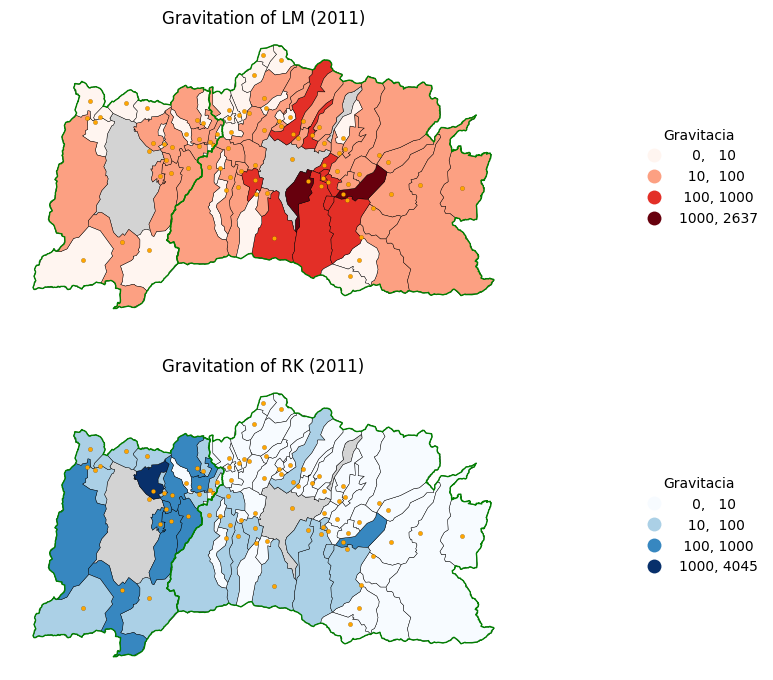

In [95]:

gravity11 = (
    commute11
    .groupby("obecB", group_keys=False)["pocet11"]
    .sum()
)
gravity11 = gravity11.reset_index()
gravity11["pocet11_lm"] = gravity11.loc[gravity11["obecB"] == "510262", "pocet11"].iloc[0]
gravity11["pocet11_rk"] = gravity11.loc[gravity11["obecB"] == "510998", "pocet11"].iloc[0]

gravity11 = gravity11.merge(
    distance[distance["mesto_id"] == "510262"][["obec_id", "vzdialenost_km"]],
    left_on = "obecB",
    right_on = "obec_id",
    how = "left"
).rename(columns = {"vzdialenost_km": "vzdialenost_lm"})

gravity11 = gravity11.merge(
    distance[distance["mesto_id"] == "510998"][["obec_id", "vzdialenost_km"]],
    left_on = "obecB",
    right_on = "obec_id",
    how = "left"
).rename(columns = {"vzdialenost_km": "vzdialenost_rk"})
gravity11 = gravity11[gravity11["vzdialenost_lm"] != 0]
gravity11 = gravity11[gravity11["vzdialenost_rk"] != 0]

gravity11["gravity_lm"] = (gravity11["pocet11"]*gravity11["pocet11_lm"]/gravity11["vzdialenost_lm"]**2)/100
gravity11["gravity_rk"] = (gravity11["pocet11"]*gravity11["pocet11_rk"]/gravity11["vzdialenost_rk"]**2)/100
# print(gravity11)
gravity11_gdf = gravity11.merge(
    map2[["IDN4", "geometry"]],
    left_on = "obecB",
    right_on = "IDN4",
    how = "left"
)
gravity11_gdf = gpd.GeoDataFrame(gravity11_gdf, geometry = "geometry")
print(type(gravity11_gdf))
plt.figure(figsize = (11.67, 8.29))
plt.subplot(2, 1, 1)
gravity11_gdf["interval"] = pd.cut(gravity11_gdf["gravity_lm"], bins = gravity_bins, include_lowest = False, labels = False)
map2.plot(
    ax = plt.gca(),
    color = "lightgray",
    edgecolor = "black",
    linewidth = 0.3
)
gravity11_gdf.plot(
    ax = plt.gca(),
    column = "gravity_lm",
    cmap = "Reds",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": gravity_bins},
    legend_kwds = {
        "title": "Gravitacia",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "green",
    linewidth = 1.0
)
plt.title("Gravitation of LM (2011)")
plt.axis(False)

plt.subplot(2, 1, 2)
gravity11_gdf["interval"] = pd.cut(gravity11_gdf["gravity_rk"], bins = gravity_bins, include_lowest = False, labels = False)
map2.plot(
    ax = plt.gca(),
    color = "lightgray",
    edgecolor = "black",
    linewidth = 0.3
)
gravity11_gdf.plot(
    ax = plt.gca(),
    column = "gravity_rk",
    cmap = "Blues",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": gravity_bins},
    legend_kwds = {
        "title": "Gravitacia",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "green",
    linewidth = 1.0
)
plt.title("Gravitation of RK (2011)")
plt.axis(False)
plt.savefig("../result_maps/gravity/LM_RK_gravity_2011.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

<class 'geopandas.geodataframe.GeoDataFrame'>


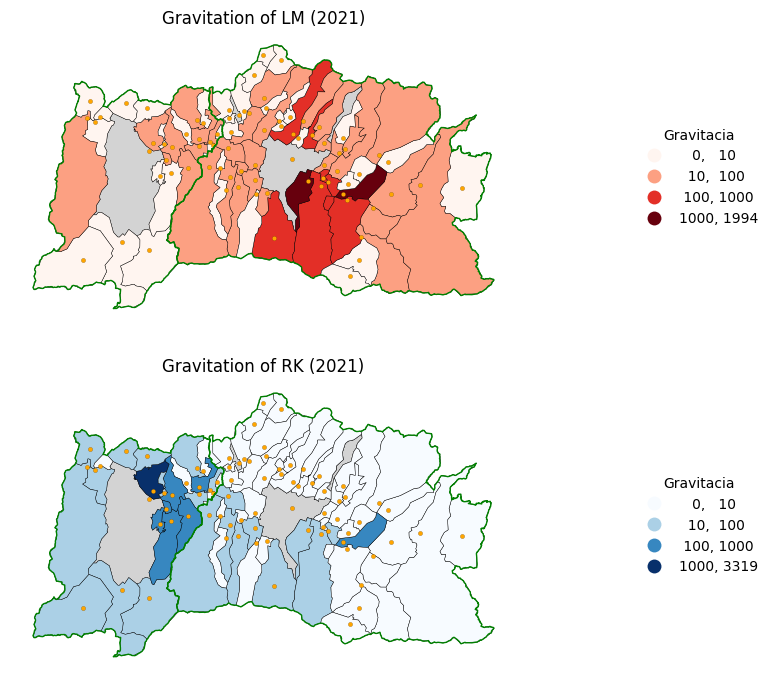

In [96]:
gravity21 = (
    commute21
    .groupby("obecB", group_keys=False)["pocet"]
    .sum()
)
gravity21 = gravity21.reset_index()
gravity21["pocet21_lm"] = gravity21.loc[gravity21["obecB"] == "510262", "pocet"].iloc[0]
gravity21["pocet21_rk"] = gravity21.loc[gravity21["obecB"] == "510998", "pocet"].iloc[0]

gravity21 = gravity21.merge(
    distance[distance["mesto_id"] == "510262"][["obec_id", "vzdialenost_km"]],
    left_on = "obecB",
    right_on = "obec_id",
    how = "left"
).rename(columns = {"vzdialenost_km": "vzdialenost_lm"})

gravity21 = gravity21.merge(
    distance[distance["mesto_id"] == "510998"][["obec_id", "vzdialenost_km"]],
    left_on = "obecB",
    right_on = "obec_id",
    how = "left"
).rename(columns = {"vzdialenost_km": "vzdialenost_rk"})
gravity21 = gravity21[gravity21["vzdialenost_lm"] != 0]
gravity21 = gravity21[gravity21["vzdialenost_rk"] != 0]
gravity_bins = [10, 100, 1000]
gravity21["gravity_lm"] = (gravity21["pocet"]*gravity21["pocet21_lm"]/gravity21["vzdialenost_lm"]**2)/100
gravity21["gravity_rk"] = (gravity21["pocet"]*gravity21["pocet21_rk"]/gravity21["vzdialenost_rk"]**2)/100
# print(gravity21)
gravity21_gdf = gravity21.merge(
    map2[["IDN4", "geometry"]],
    left_on = "obecB",
    right_on = "IDN4",
    how = "left"
)
gravity21_gdf = gpd.GeoDataFrame(gravity21_gdf, geometry = "geometry")
print(type(gravity21_gdf))
plt.figure(figsize = (11.67, 8.29))
plt.subplot(2, 1, 1)
gravity21_gdf["interval"] = pd.cut(gravity21_gdf["gravity_lm"], bins = gravity_bins, include_lowest = False, labels = False)
map2.plot(
    ax = plt.gca(),
    color = "lightgray",
    edgecolor = "black",
    linewidth = 0.3
)
gravity21_gdf.plot(
    ax = plt.gca(),
    column = "gravity_lm",
    cmap = "Reds",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": gravity_bins},
    legend_kwds = {
        "title": "Gravitacia",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "green",
    linewidth = 1.0
)
plt.title("Gravitation of LM (2021)")
plt.axis(False)

plt.subplot(2, 1, 2)
gravity21_gdf["interval"] = pd.cut(gravity21_gdf["gravity_rk"], bins = gravity_bins, include_lowest = False, labels = False)
map2.plot(
    ax = plt.gca(),
    color = "lightgray",
    edgecolor = "black",
    linewidth = 0.3
)
gravity21_gdf.plot(
    ax = plt.gca(),
    column = "gravity_rk",
    cmap = "Blues",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": gravity_bins},
    legend_kwds = {
        "title": "Gravitacia",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "green",
    linewidth = 1.0
)
plt.title("Gravitation of RK (2021)")
plt.axis(False)
plt.savefig("../result_maps/gravity/LM_RK_gravity_2021.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()